# Spinal cord injury analysis

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

## Dataset

The data comes from the National Spinal Cord Injury Statistical Center (NSCISC).

Unpack it a `data` directory as follows for scripts to find it:
```
data
├── f1_public_2021.csv
└── f2_public_2021.csv
```

The two files contain responses to two forms, f1 and f2. The first form is administered at injury time. The second is recurring, first one year after the injury, then five, then every five years after this.

The vast majority of columns are categories whose definitions are given in a data dictionary, but we keep them as strings and integers for now to facilitate computations. The columns explicitely listed below contain a mix of integers and strings (e.g. `32` and `"6-12y"`) so we import them as strings to avoid warnings.

In [2]:
df1 = pd.read_csv(
    "data/f1_public_2021.csv",
    dtype={col_name: str for col_name in ['AExtCsIj', 'AASAImAd', 'AASAImDs', 'AInjAge']},
)
df2 = pd.read_csv(
    "data/f2_public_2021.csv",
    dtype={col_index: str for col_index in ['BASAImp']},
)

The two forms have a single column in common, a unique ID per patient called `UniID`, so we can merge them into a single long-form dataframe.

In [3]:
df = pd.merge(df2, df1, on='UniID', how='left')

Let's look at how many records we're starting with:

In [4]:
df1.shape[0], df2.shape[0], df.shape[0]

(35675, 131217, 131217)

## Research questions

We'd like to answer the following questions:

1. Do people with high functional scores still report low engagement in leisure or screen-based activities?
2. Do higher depression scores correlate with lower leisure/screen engagement?
3. Are younger people more likely to engage in screen-based leisure?
4. Do mobility users report lower participation?
5. Is lower income associated with reduced leisure and higher depression?

To do that, we have to identify the relevant columns and compute some aggregated scores. Let's start with functional scores.

In [5]:
functional_columns = {
    'ACrEat': 'Self-Care A. Eating',
    'ACrOrl': 'Self-Care B. Oral Hygiene',
    'ACrTlHy': 'Self-Care C. Toileting hygiene',
    'ACrShr': 'Self-Care E. Shower/bathe self',
    'ACrUpDr': 'Self-Care F. Upper body dressing',
    'ACrLrDr': 'Self-Care G. Lower body dressing',
    'ACrFtr': 'Self-Care H. Putting on/taking off footwear',
    'ACrRll': 'Mobility A. Roll left to right',
    'ACrStLy': 'Mobility B. Sitting to lying',
    'ACrLySt': 'Mobility C. Lying to sitting on side of bed',
    'ACrStSd': 'Mobility D. Sit to stand',
    'ACrChrT': 'Mobility E. Chair/bed-to-chair transfer',
    'ACrTltT': 'Mobility F. Toilet transfer',
    'ACrCar': 'Mobility G. Car transfer',
    'ACrWa10': 'Walk I. Walk 10 feet',
    'ACrW502': 'Walk J. Walk 50 feet with 2 turns',
    'ACrW150': 'Walk K. Walk 150 feet',
    'ACrWaUn': 'Walk L. Walk 10 feet on uneven surface',
    'ACr1Stp': 'Walk M. 1 step (curb)',
    'ACr4Stp': 'Walk N. 4 steps',
    'ACr12St': 'Walk O. 12 steps',
    'ACrPiUp': 'Walk P. Picking up object',
    'ACrCh50': 'Wheel R. Wheel 50 feet with 2 turns',
    'ACrC150': 'Wheel S. Wheel 150 feet',
}

All these columns correspond to functional scores and share the same response category.

In [6]:
functional_category = {
  1: 'Dependent',
  2: 'Substantial/maximal assistance',
  3: 'Partial/moderate assistance',
  4: 'Supervision or Touching Assistance',
  5: 'Setup or clean-up assistance',
  6: 'Independent',
  7: 'Patient Refused',
  9: 'Not applicable',
  10: 'Not attempted due to environmental limitations',
  88: 'Not attempted due to medical condition or safety concerns',
  99: 'Unknown, No rehab admit',
}

Note that we exclude:
- `ACrCh`: Wheel Q. Does patient use wheelchair/scooter
- `ACrT50`: Wheel RR Type of wheelchair/scooter used
- `ACrT150`: Wheel SS 150 Ft Type of wheelchair/scooter used

even though they are functional responses because they use a different category (yes/no).

Also note that each column actually maps to two columns because the same questions get evaluated twice, once at the start of rehab and once at discharge. They're differentiated by the suffixes `R` and `D`.

In [7]:
functional_columns = [f'{key}{suffix}' for key in functional_columns.keys() for suffix in ['R', 'D']]

Next we can compute the average functional score. Since it's only using data from form 1, we prefix the new column with `A` for consistency.

We must be careful to exclude invalid values.

In [8]:
df1['AFunctionalScore'] = df1[functional_columns][df1[functional_columns] < 7].dropna(how='all', axis=0).mean(axis=1)

Let's add that new colum to `df`.

In [9]:
df = pd.merge(df, df1[['UniID', 'AFunctionalScore']], on='UniID', how='left')

How many rows did we drop for lack of any functional scores?

In [10]:
(
    df1.dropna(subset='AFunctionalScore').shape[0],
    df1.dropna(subset='AFunctionalScore').shape[0] / df1.shape[0],
    df.dropna(subset='AFunctionalScore').shape[0],
    df.dropna(subset='AFunctionalScore').shape[0] / df.shape[0],
)
# (3249, 0.09107217939733707, 2215, 0.016880434699772132)

(3249, 0.09107217939733707, 2215, 0.016880434699772132)

Sadly, that's a 91% reduction in terms of form 1 and 99% for form 2.

We can also try a different set of columns that should also capture a functional score.

In [11]:
functional_alt_columns = {
    'ASFBMTS': 'Basic Mobility T-Score',
    'ASFSCTS': 'Self-Care T-Score',
    'ASFFMoTS': 'Fine Motor T-Score',
    'ASFAmbTS': 'Ambulation T-Score',
    'ASFMWhTS': 'Manual Wheelchair Mobility T-Score',
    'ASFPWhTS': 'Power Wheelchair Mobility T-Score',
}

In [12]:
functional_alt_columns = functional_alt_columns.keys()

In [13]:
df1["AFunctionalAltScore"] = (
    df1[functional_alt_columns][
        (df1[functional_alt_columns] >= 0) & (df1[functional_alt_columns] <= 100)
    ]
    .dropna(how="all", axis=0)
    .mean(axis=1)
)

In [14]:
df = pd.merge(df, df1[['UniID', 'AFunctionalAltScore']], on='UniID', how='left')

In [15]:
(
    df1.dropna(subset='AFunctionalAltScore').shape[0],
    df1.dropna(subset='AFunctionalAltScore').shape[0] / df1.shape[0],
    df.dropna(subset='AFunctionalAltScore').shape[0],
    df.dropna(subset='AFunctionalAltScore').shape[0] / df.shape[0],
)

(3241, 0.0908479327259986, 2292, 0.017467248908296942)

Unfortunately, we get a similar reduction in entries.

For depression, we can use pre-calculated columns. `ABPHQMDS` (PHQ-9 Major Depressive Syndrome) is a three-level scale (major/other/none) that gets calculated based on specific criteria. `ABPHQSDS` (PHQ-Severity of Depression) is the sum of responses to individual screening questions so is more granular (0 to 27) but does not map to a specific diagnostic. We'll stick with `ABPHQMDS` for now.

In [16]:
depression_columns = ['ABPHQMDS']

In [17]:
depression_category = {
    0: 'No depressive syndrome',
    1: 'Major depressive syndrome',
    2: 'Other depressive syndrome',
    7: 'Declined',
    9: 'Unknown, interview not done, age <18',
}

Even if it's a single column, let's create a new column excluding invalid entries.

In [18]:
df1['ADepressionScore'] = df1[depression_columns][df1[depression_columns] < 3].dropna(how='all', axis=0)
df = pd.merge(df, df1[['UniID', 'ADepressionScore']], on='UniID', how='left')

For form 1, the age at time of injury is provided. For form 2, the age is calculated by summing the age at time of injury with the years since the injury happened. But since ages for minors and seniors are reported as age group strings like `6-12y` or `88+`, we have to add years since the injury to individual numbers within each string.

In [19]:
def add(text, num):
    return re.sub(r'\d+', lambda match: str(int(match.group(0)) + num), text)

It's important to use the correct age column depending on the form. Thankfully column names are prefixed with `A` or `B` depending on the form, so we use that same convention to compute the age for form 2.

In [20]:
df['BAge'] = df.apply(lambda row: add(row['AInjAge'], row['BYear']), axis=1)

Mobility questions are a subset of functional questions.

In [21]:
mobility_columns = {
    'ACrRll': 'Mobility A. Roll left to right',
    'ACrStLy': 'Mobility B. Sitting to lying',
    'ACrLySt': 'Mobility C. Lying to sitting on side of bed',
    'ACrStSd': 'Mobility D. Sit to stand',
    'ACrChrT': 'Mobility E. Chair/bed-to-chair transfer',
    'ACrTltT': 'Mobility F. Toilet transfer',
    'ACrCar': 'Mobility G. Car transfer',
    'ACrWa10': 'Walk I. Walk 10 feet',
    'ACrW502': 'Walk J. Walk 50 feet with 2 turns',
    'ACrW150': 'Walk K. Walk 150 feet',
    'ACrWaUn': 'Walk L. Walk 10 feet on uneven surface',
    'ACr1Stp': 'Walk M. 1 step (curb)',
    'ACr4Stp': 'Walk N. 4 steps',
    'ACr12St': 'Walk O. 12 steps',
    'ACrPiUp': 'Walk P. Picking up object',
    'ACrCh50': 'Wheel R. Wheel 50 feet with 2 turns',
    'ACrC150': 'Wheel S. Wheel 150 feet',
}
mobility_columns = [f'{key}{suffix}' for key in mobility_columns.keys() for suffix in ['R', 'D']]

In [22]:
df1['AMobilityScore'] = df1[mobility_columns][df1[mobility_columns] < 7].dropna(how='all', axis=0).mean(axis=1)
df = pd.merge(df, df1[['UniID', 'AMobilityScore']], on='UniID', how='left')

Income is readily available in both forms, as a category.

In [23]:
income_columns = ['AFmIncLv', 'BFmIncLv']

In [24]:
income_category = {
    1: '< $25,000',
    2: '$25,000 - $49,999',
    3: '$50,000 - $74,999',
    4: '$75,000 plus',
    6: 'Participant doesn’t know',
    7: 'Declined',
    9: 'Unknown/Interview not done',
}

In [25]:
df[['AIncome', 'BIncome']] = df[income_columns][df[income_columns] < 6].dropna(how='all', axis=0)

Leisure and screen-based activities are central to the research questions we're trying to answer yet there is very little relevant corresponding data. We have to content ourselves with indirect answers like _I found new things to enjoy_ or _Internet or Email Usage, how often_.

In [26]:
leisure_columns = ['ARsNewTh']

In [27]:
screen_based_activities_columns = ['BInetEml']

Unfortunately, those columns don't figure in the data dictionary so we don't know for sure what categories they use. However, we can guess their range and still compute a score.

In [28]:
leisure_category = {
    1: 'Not at all',
    2: 'A little bit',
    3: 'Somewhat',
    4: 'Quite a bit',
    5: 'Very much',
    7: 'Declined',
    9: 'Unknown, Interview not done, age < 18',
}

In [29]:
screen_based_activities_category = {
    0: 'Never',
    1: 'Rarely',
    2: 'Often',
    3: 'All the time',
    8: 'Declined',
    9: 'Unknown, Interview not done, age < 18',
}

Let's add columns for them too.

In [30]:
df1['ALeisureScore'] = df1[leisure_columns][df1[leisure_columns] < 6].dropna(how='all', axis=0)
df = pd.merge(df, df1[['UniID', 'ALeisureScore']], on='UniID', how='left')

In [31]:
df['BScreenScore'] = df[screen_based_activities_columns][df[screen_based_activities_columns] < 4].dropna(how='all', axis=0)

Lastly, we need to measure participation. I interpret this to mean participation in social activities, rather than participation to the survey which would be hard to measure. We'll use the _social integration_ computed column `BCHSocIn` which is a score between 0 and 100.

In [32]:
participation_columns = ['BCHSocIn']

In [33]:
df['BParticipationScore'] = df[participation_columns][df[participation_columns] < 101].dropna(how='all', axis=0)

## Control variables

To better answer the research questions, we need to include control variables that might represent confounding factors in our analysis.

We already loaded the age but there is more demographic and socioeconomic data that is relevant.

In [34]:
demographic_columns = [
    'ASex', # Sex
    'ARace', # Racial or Ethnic Group
    'AHispnic', # Hispanic Origin
]
socioeconomic_columns = [
    'AEducLvl', # Highest Formal Educational Level Completed at Injury
    'BEducLvl', # Highest Formal Educational Level Completed
    'AMarStIj', # Marital Status at Injury 
    'BMarStat', # Marital Status on the Anniversary
    'APrLvlSt', # Primary Occupational, Educational or Training Status
    'BPrLvlSt', # Primary Occupational, Educational or Training Status
]

Relatedly, we can include social and environmental controls which can affect access to activities and social support.

In [35]:
living_situation_columns = [
    'APResInj', # Place of residence at injury
    'APResDis', # Place of residence at discharge
    'BPlcRes', # Place of residence at follow-up
]
social_participation_columns = [
    # 'BCHSocIn', # CHART Social Integration (already using this as participation)
    'BCHPITot', # CHART Physical Independence Total
    'BCHMbTot', # CHART Mobility Total
    'BCHOpTot', # CHART Occupation Total
]

Also relevant are health/injury severity variables.

In [36]:
injury_columns = [
    'ANurLvlA', # Neurologic level of injury at acute med unit admit 
    'ANurLvlR', # Neurologic level of injury at admit to rehab
    'ANurLvlD', # Neurologic level of injury at discharge
    'BNurLvl', # Neurologic level of injury at annual exam
    'AASAImAd', # ASIA Impairment Scale at acute med unit exam
    'AASAImRb', # ASIA Impairment Scale at admit to system inpatient rehab
    'AASAImDs', # ASIA Impairment Scale at discharge
    'BASAImp', # ASIA Impairment Scale at annual exam
]
pain_columns = [
    'BPainSev', # Pain usual level last 4 weeks
    'BPainWrk', # Pain interference last 4 weeks
]
health_columns = [
    'ADiabete', # Diabetes, diagnosed lifetime
    'AHypTen', # Hypertension, diagnosed lifetime
    'AHypLip', # Hyperlipidemia, diagnosed lifetime
    'AArthr', # Arthritis, diagnosed lifetime
    'BDiabete', # Diabetes, current
    'BHyptnCu', # Hypertension, current
    'BHyplpCu', # Hyperlipidemia, current
    'BArthrCu', # Arthritis, current
]
health_perception_columns =[
    'BSPHthSt', # Self-perceived health status
    'BSPHthRC', # Compared to 1 year ago, rate your health now
]

Also substance use.

In [37]:
substance_use_columns = [
    'AAlcRate', # AUDIT C - how often have a drink
    'BAlcRate', # AUDIT C - how often have a drink
    'AAlcNbDr', # AUDIT C - drinks on typical day
    'BAlcNbDr', # AUDIT C - drinks on typical day
    'AAlc6Mor', # AUDIT C - 6 or more drinks on one occasion
    'BAlc6Mor', # AUDIT C - 6 or more drinks on one occasion
    'ASATob', # WHO ASSIST score - Tobacco
    'BSATob', # WHO ASSIST score - Tobacco
    'ASACann', # WHO ASSIST score - Cannabis
    'BSACann', # WHO ASSIST score - Cannabis
    'ASACoc', # WHO ASSIST score - Cocaine
    'BSACoc', # WHO ASSIST score - Cocaine
    'ASAAmph', # WHO ASSIST score - Amphetamine-type
    'BSAAmph', # WHO ASSIST score - Amphetamine-type
    'ASAInhl', # WHO ASSIST score - Inhalants
    'BSAInhl', # WHO ASSIST score - Inhalants
    'ASASed', # WHO ASSIST score - Sedatives/Sleeping
    'BSASed', # WHO ASSIST score - Sedatives/Sleeping
    'ASAHall', # WHO ASSIST score - Hallucinogens
    'BSAHall', # WHO ASSIST score - Hallucinogens
    'ASAOpd', # WHO ASSIST score - Opiods
    'BSAOpd', # WHO ASSIST score - Opiods
    'ASAOthr', # WHO ASSIST score - Other
    'BSAOthr', # WHO ASSIST score - Other
]

And medical history.

In [38]:
mental_health_columns = [
    'AAnxiety', # Lifetime history of anxiety diagnosis
    'ADepress', # Lifetime history of depression diagnosis
]
hospitalizations_columns = [
    'BRhspNbr', # Number of rehospitalizations during last 12 months
    'BRhspDaT', # Days rehospitalized during last 12 months
]

Lastly some technology access columns.

In [39]:
technology_columns = [
    'BCompUse', # Use a computer?
    'BCmpAsst', # Computer assistance from another
    'BCellPhn', # Cell phone usage
]

## Preliminary analysis

Let's start with very simple regression plots to get a sense of the data.

### Question 1

> Do people with high functional scores still report low engagement in leisure or screen-based activities?

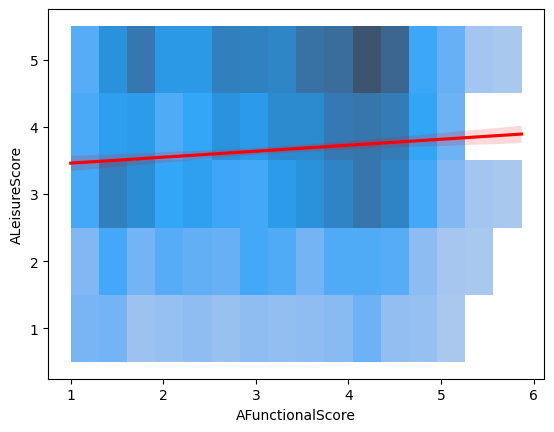

In [40]:
sns.histplot(df, x='AFunctionalScore', y='ALeisureScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

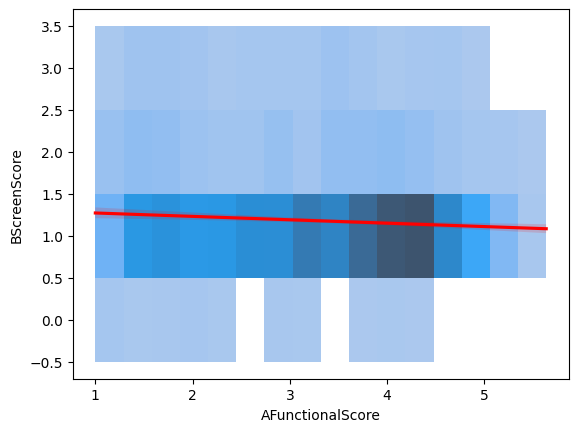

In [41]:
sns.histplot(df, x='AFunctionalScore', y='BScreenScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

Let's also try with the alternative functional score.

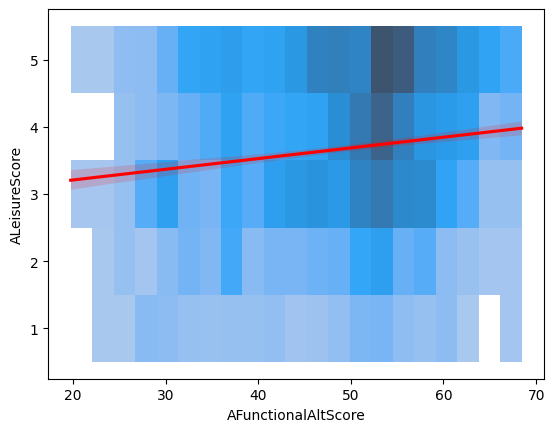

In [42]:
sns.histplot(df, x='AFunctionalAltScore', y='ALeisureScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalAltScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

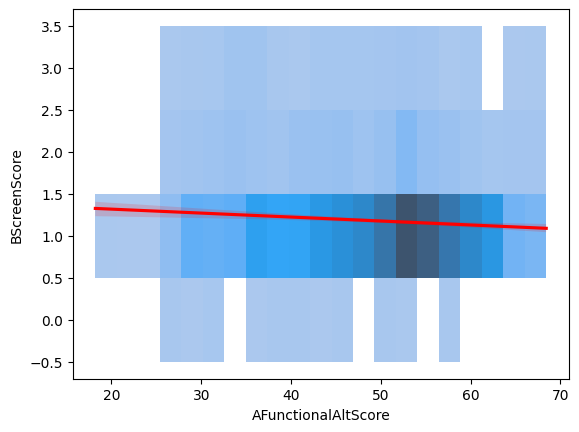

In [43]:
sns.histplot(df, x='AFunctionalAltScore', y='BScreenScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalAltScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

### Question 2

> Do higher depression scores correlate with lower leisure/screen engagement?

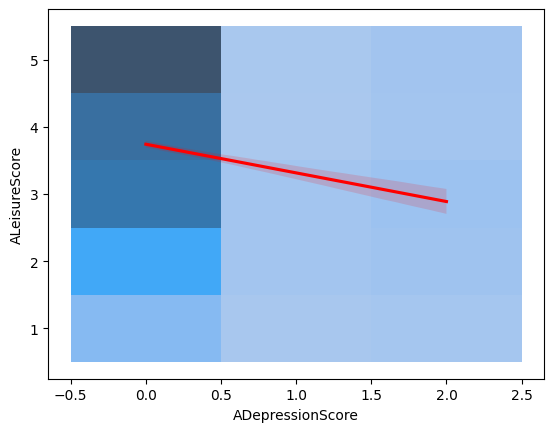

In [44]:
sns.histplot(df, x='ADepressionScore', y='ALeisureScore', discrete=(True, True))
sns.regplot(df, x='ADepressionScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

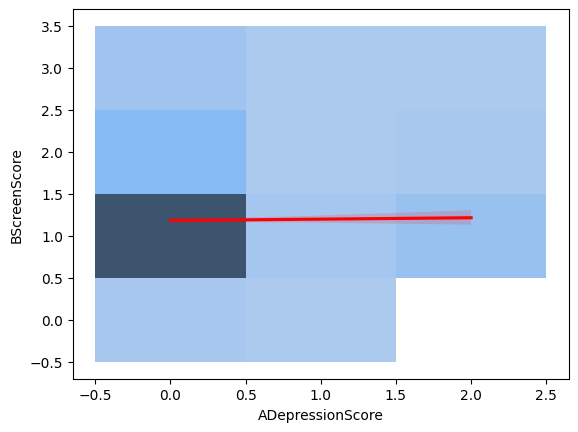

In [45]:
sns.histplot(df, x='ADepressionScore', y='BScreenScore', discrete=(True, True))
sns.regplot(df, x='ADepressionScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

### Question 3

> Are younger people more likely to engage in screen-based leisure?

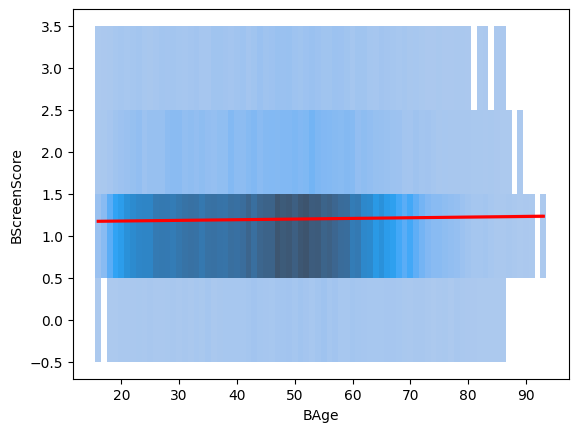

In [46]:
sub = df[df['BAge'].str.isnumeric()].copy()
sub['BAge'] = sub['BAge'].astype(int)
sns.histplot(sub, x='BAge', y='BScreenScore', discrete=(True, True))
sns.regplot(sub, x='BAge', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

### Question 4

> Do mobility users report lower participation?

Note: not sure if _mobility user_ means something specific or if the question is just missing a word (_low_).

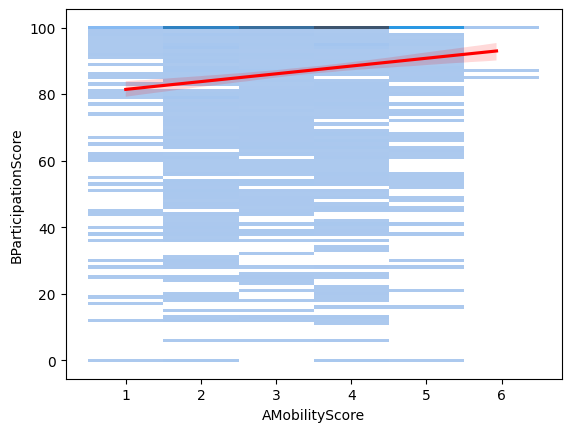

In [47]:
sns.histplot(df, x='AMobilityScore', y='BParticipationScore', discrete=(True, True))
sns.regplot(df, x='AMobilityScore', y='BParticipationScore', marker='', line_kws={'color':'r'})
plt.show()

### Question 5

> Is lower income associated with reduced leisure and higher depression?

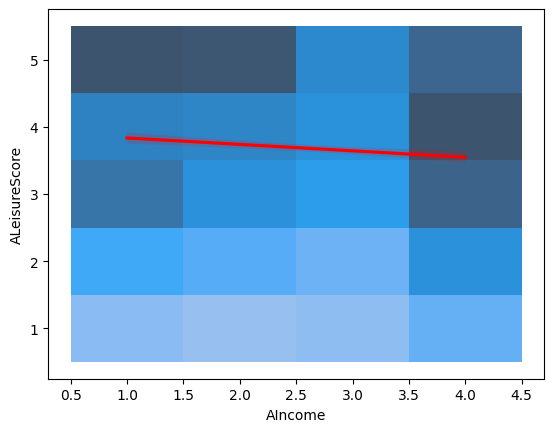

In [48]:
sns.histplot(df, x='AIncome', y='ALeisureScore', discrete=(True, True))
sns.regplot(df, x='AIncome', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

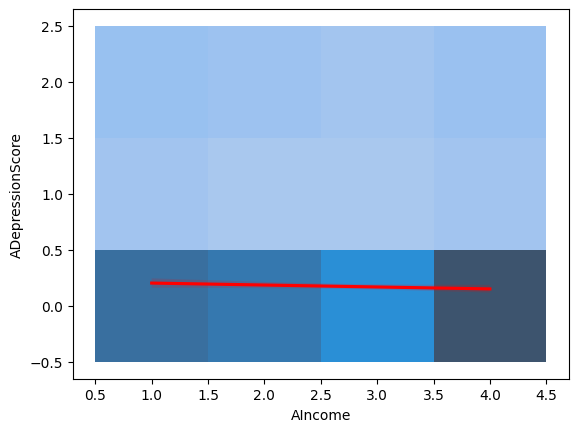

In [49]:
sns.histplot(df, x='AIncome', y='ADepressionScore', discrete=(True, True))
sns.regplot(df, x='AIncome', y='ADepressionScore', marker='', line_kws={'color':'r'})
plt.show()

## Linear analysis

Let's now build a linear model taking into account all the control variables.

### Question 1

> Do people with high functional scores still report low engagement in leisure or screen-based activities?

We'll fit an OLS model for `ALeisureScore` using `AFunctionalScore` and the control variables defined above, then visualise the relationship and the model coefficients.

In [50]:
continuous_controls = {
    "BCHPITot": lambda n: n < 101,
    "BCHMbTot": lambda n: n < 101,
    "BCHOpTot": lambda n: n < 101,
    "BRhspNbr": lambda n: n < 8,
    "BRhspDaT": lambda n: n < 888,
    "BPainSev": lambda n: n < 888,
}
categorical_controls = [
    col
    for col in demographic_columns
    + socioeconomic_columns
    + living_situation_columns
    + social_participation_columns
    + injury_columns
    + pain_columns
    + health_columns
    + health_perception_columns
    + substance_use_columns
    + mental_health_columns
    + hospitalizations_columns
    + technology_columns
    if col not in continuous_controls.keys()
]

In [51]:
# Define variables for the model
dependent_var = 'ALeisureScore'
main_independent_var = 'AFunctionalScore'

# --- Prepare data for model ---

# Ensure all control vars exist in df, some might be from f1 or f2
# (This assumes 'categorical_controls' and 'continuous_controls' exist from prior cells)
continuous_in_model = [col for col in continuous_controls.keys() if col in df.columns]
categorical_in_model = [col for col in categorical_controls if col in df.columns]

# Use the filter functions in continuous_controls to drop invalid values
for col in continuous_in_model:
    filter_func = continuous_controls[col]
    df = df[df[col].isna() | df[col].apply(filter_func)]

# Create the independent variables DataFrame
# Start with the main predictor
X = df[[main_independent_var]].copy()

# Add continuous controls
X[continuous_in_model] = df[continuous_in_model]

# Add categorical controls as dummy variables
# Note: The notebook filled NaNs with 0, so 0 is the 'Missing' category.
# We'll drop one category to avoid multicollinearity.
for col in categorical_in_model:
    # Convert to category type first then create dummies
    dummies = pd.get_dummies(df[col].astype('category'), prefix=col, dtype=int)
    X = pd.concat([X, dummies], axis=1)

# Define the dependent variable
y = df[dependent_var]

# Add a constant (intercept) to the model
X_with_const = sm.add_constant(X, prepend=False)

# --- Fit the OLS model ---
# We use missing='drop' to handle any remaining NaNs
# (e.g., in continuous controls, the main predictor, or y)
model = sm.OLS(y, X_with_const, missing='drop')
results = model.fit()

# Print the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          ALeisureScore   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     1.448
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           1.47e-06
Time:                        16:45:40   Log-Likelihood:                -2431.0
No. Observations:                1695   AIC:                             5632.
Df Residuals:                    1310   BIC:                             7725.
Df Model:                         384                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
AFunctionalScore     0.1254      0.048  

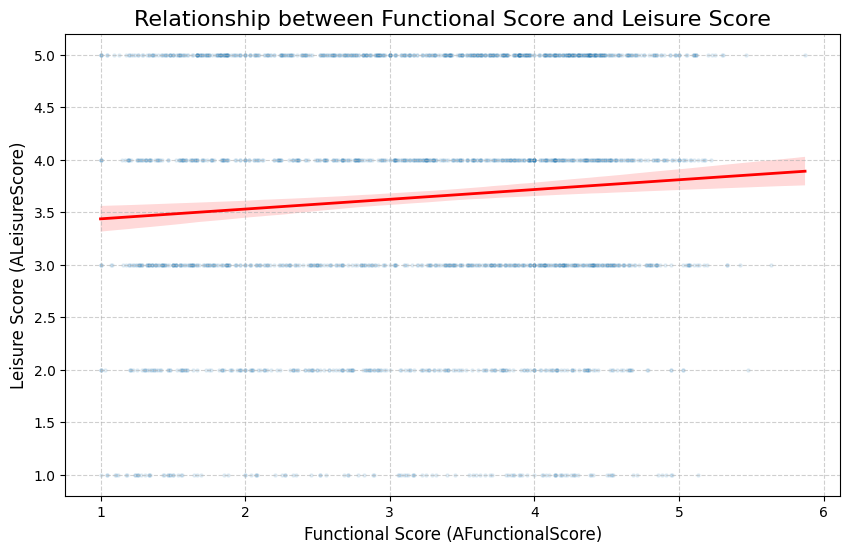

In [52]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x='AFunctionalScore',
    y='ALeisureScore',
    scatter_kws={'alpha': 0.1, 's': 5}, # Make points transparent and small
    line_kws={'color': 'red', 'linewidth': 2}
)
plt.title('Relationship between Functional Score and Leisure Score', fontsize=16)
plt.xlabel('Functional Score (AFunctionalScore)', fontsize=12)
plt.ylabel('Leisure Score (ALeisureScore)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

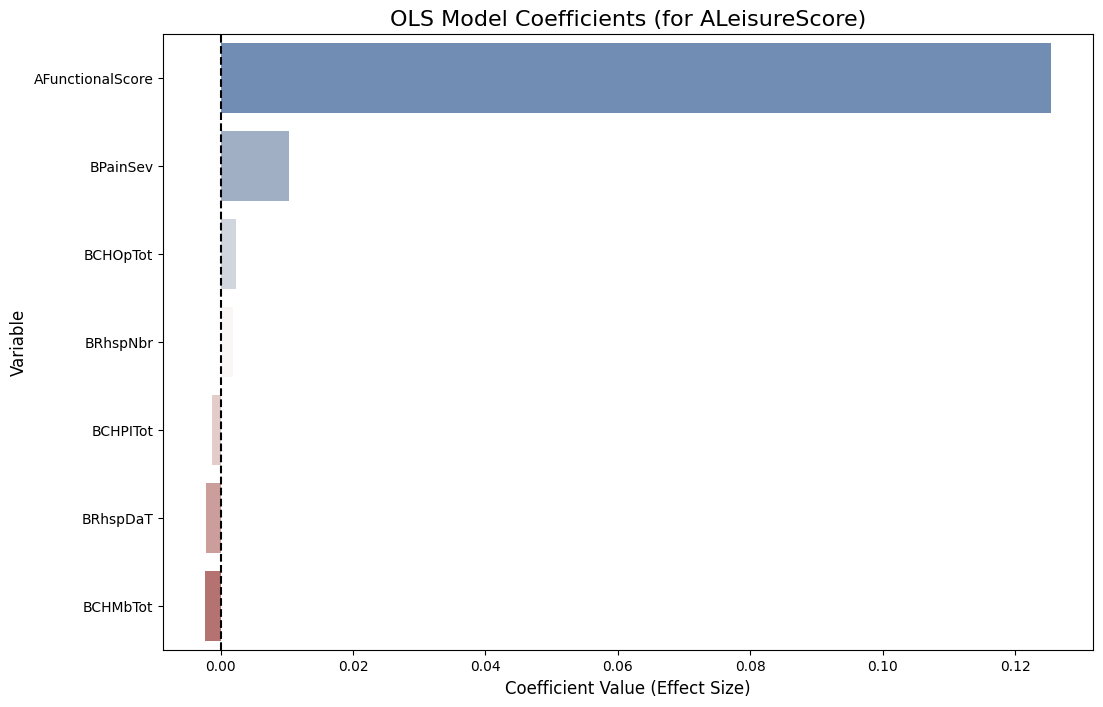

In [53]:
coefs = results.params.drop('const')

# Get 95% confidence intervals
conf_int = results.conf_int().drop('const')

# Combine into a DataFrame for plotting
coef_df = pd.DataFrame({
    'Coefficient': coefs,
    'Conf. Int. Lower': conf_int[0],
    'Conf. Int. Upper': conf_int[1]
}).reset_index().rename(columns={'index': 'Variable'})

# Calculate the error (half the width of the CI)
coef_df['Error'] = (coef_df['Conf. Int. Upper'] - coef_df['Conf. Int. Lower']) / 2

# For better visualization, let's just plot the main variable
# and the continuous control variables. Plotting all dummy
# variables can be very noisy.
vars_to_plot = [main_independent_var] + continuous_in_model

# Filter the coef_df
plot_data = coef_df[coef_df['Variable'].isin(vars_to_plot)]

# Sort by coefficient value for a cleaner plot
plot_data = plot_data.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
# Use a bar plot with error bars
sns.barplot(
    data=plot_data,
    x='Coefficient',
    y='Variable',
    hue='Variable',
    palette='vlag', # A diverging palette is good for +/- values
    # xerr='Error', # Add error bars from CI
)
plt.axvline(x=0, color='black', linestyle='--') # Add a line at zero
plt.title('OLS Model Coefficients (for ALeisureScore)', fontsize=16)
plt.xlabel('Coefficient Value (Effect Size)', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.show()

So the multi-variate linear model with control variables does not seem to be doing much better than a simple linear regression.

Next we can try a random forest model.

Data split: 1708 training, 428 testing.

Training Random Forest model...
Model training complete.

Model Out-of-Bag (OOB) R-squared: 0.0350
--- Test Set Performance ---
Test R-squared: 0.0134
Test RMSE:      1.2036

Generating plots...


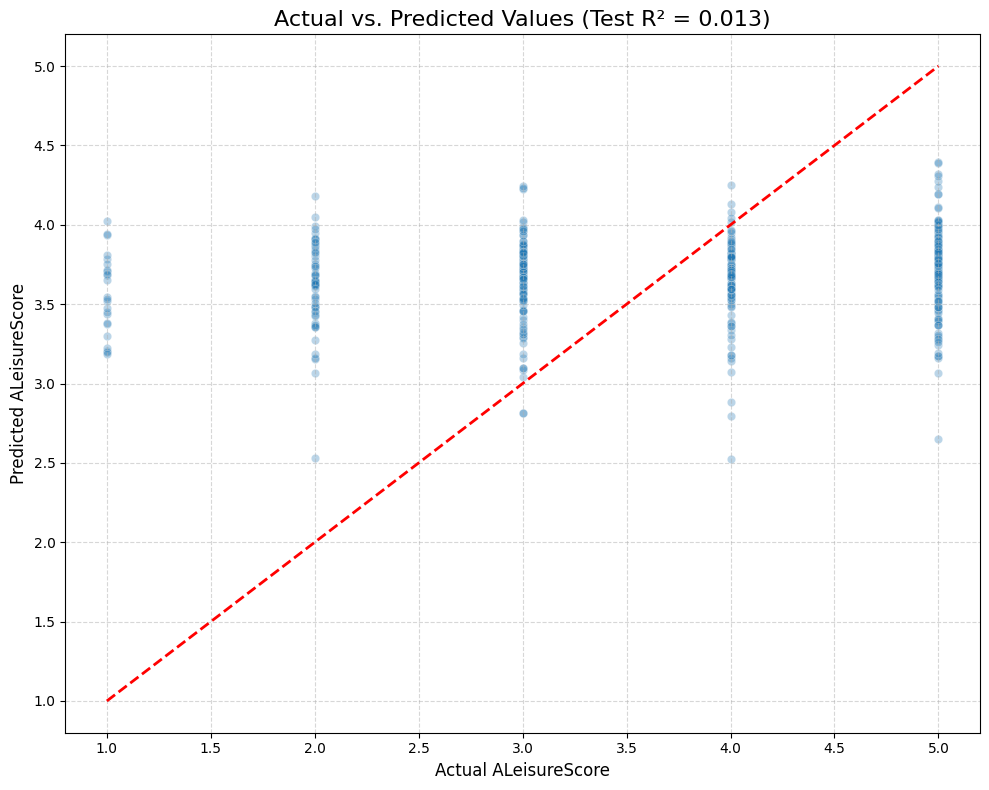

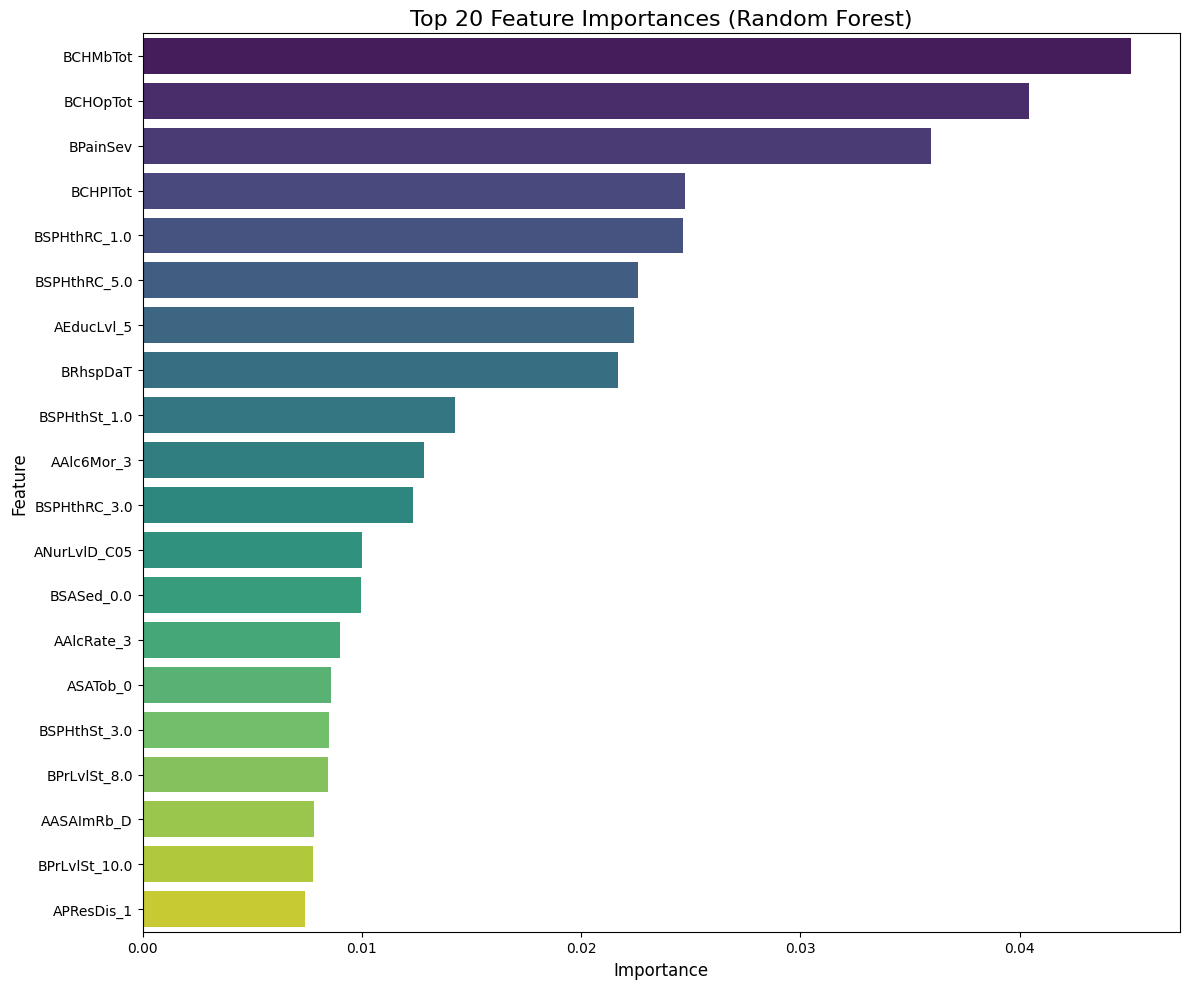

In [54]:
# Import imputation, preprocessing, and pipeline tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import the model and evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

TARGET = "ALeisureScore"
ALL_FEATURES = continuous_in_model + categorical_in_model


def create_preprocessing_pipeline():
    """
    Creates a scikit-learn pipeline to handle imputation, scaling,
    and one-hot encoding.
    """

    # --- Create Transformers ---

    # Pipeline for continuous features:
    # 1. Impute missing values with the median (robust to outliers)
    # 2. Scale features (good practice, though RF is less sensitive)
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    # Pipeline for categorical features:
    # 1. Impute missing values with the most frequent value
    # 2. One-hot encode the categories
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ]
    )

    # --- Combine Transformers with ColumnTransformer ---
    # This applies the correct transformer to the correct columns
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, continuous_in_model),
            ("cat", categorical_transformer, categorical_in_model),
        ],
        remainder="passthrough",  # Keep any other columns (though we don't have any)
    )

    return preprocessor


def run_random_forest_analysis(df: pd.DataFrame):
    """
    Trains, evaluates, and plots a Random Forest model.
    """

    df.dropna(subset=TARGET, inplace=True)

    # --- 1. Define X and y ---
    X = df[ALL_FEATURES]
    y = df[TARGET]

    # --- 2. Train-Test Split ---
    # We MUST split the data to get an honest assessment of model performance.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"Data split: {len(X_train)} training, {len(X_test)} testing.")

    # --- 3. Create Preprocessor and Model ---
    preprocessor = create_preprocessing_pipeline()

    # Define the Random Forest Regressor
    # n_estimators=100 is a good default.
    # max_depth=10 helps prevent overfitting.
    # n_jobs=-1 uses all available CPU cores.
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
        oob_score=True,  # Out-of-bag score is a good cross-validation estimate
    )

    # --- 4. Create Full Pipeline ---
    # This bundles preprocessing and modeling.
    # When we call .fit(), it will:
    # 1. Fit the preprocessor on X_train (find medians, categories, etc.)
    # 2. Transform X_train
    # 3. Train the Random Forest on the transformed X_train
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", rf_model)])

    # --- 5. Train the Model ---
    print("\nTraining Random Forest model...")
    pipeline.fit(X_train, y_train)
    print("Model training complete.")

    # --- 6. Evaluate the Model ---

    # Get OOB score (a built-in estimate of R^2 on unseen data)
    oob_score = pipeline.named_steps["model"].oob_score_
    print(f"\nModel Out-of-Bag (OOB) R-squared: {oob_score:.4f}")

    # Make predictions on the *test set*
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    r2_test = r2_score(y_test, y_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"--- Test Set Performance ---")
    print(f"Test R-squared: {r2_test:.4f}")
    print(f"Test RMSE:      {rmse_test:.4f}")

    # --- 7. Plotting ---
    print("\nGenerating plots...")

    # Plot 1: Actual vs. Predicted
    plot_actual_vs_predicted(y_test, y_pred, r2_test)

    # Plot 2: Feature Importance
    plot_feature_importance(pipeline, X_train)

    plt.show()


def plot_actual_vs_predicted(y_test, y_pred, r2_test):
    """
    Generates a scatter plot of actual vs. predicted values.
    """
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)

    # Add a y=x line for reference
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", lw=2)

    plt.title(f"Actual vs. Predicted Values (Test R² = {r2_test:.3f})", fontsize=16)
    plt.xlabel("Actual ALeisureScore", fontsize=12)
    plt.ylabel("Predicted ALeisureScore", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    # plt.savefig("rf_actual_vs_predicted.png")


def plot_feature_importance(pipeline, X_train):
    """
    Extracts and plots feature importances from the Random Forest model.
    """
    # --- Get Feature Names After Preprocessing ---

    # Access the preprocessor
    preprocessor = pipeline.named_steps["preprocessor"]

    # Get the fitted categorical transformer
    cat_transformer = preprocessor.named_transformers_["cat"]
    onehot_encoder = cat_transformer.named_steps["onehot"]

    # Get the feature names from the one-hot encoder
    # This will give names like 'Sex_1.0', 'Sex_2.0', etc.
    categorical_features = onehot_encoder.get_feature_names_out(categorical_in_model)

    # Combine with the continuous features
    all_processed_features = np.concatenate([continuous_in_model, categorical_features])

    # --- Get Importances from Model ---
    model = pipeline.named_steps["model"]
    importances = model.feature_importances_

    # Create a pandas Series for easy sorting and plotting
    importance_series = pd.Series(importances, index=all_processed_features)

    # Get the top 20 features
    top_20_features = importance_series.sort_values(ascending=False).head(20)

    # --- Plot ---
    plt.figure(figsize=(12, 10))
    sns.barplot(
        x=top_20_features.values,
        y=top_20_features.index,
        hue=top_20_features.index,  # Use hue to get different colors
        palette="viridis",
        legend=False,  # Disable legend
    )
    plt.title("Top 20 Feature Importances (Random Forest)", fontsize=16)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    # plt.savefig("rf_feature_importance.png")


run_random_forest_analysis(df)